## RMMS to df

In [1]:
# pip install lxml beautifulsoup4 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import lxml
from bs4 import BeautifulSoup
import requests

from IPython.display import display
from shapely.geometry import Point
import geopandas as gpd

In [3]:
## FIX THIS ONE
file_path = 'Assessment1/testfile/RMMS/RMMS/N1.traffic.htm'

### First try for only the N1

In [4]:
file_path = '../Assessment1/testfile/RMMS/RMMS/N1.traffic.htm'

# Step 1: Read the HTML table without skipping any rows initially
tables = pd.read_html(file_path, flavor='lxml')

# Step 2: Use the correct table index (based on your inspection, it's likely index 0)
raw_df = tables[2]

# Step 3: Drop rows that are entirely NaN
raw_df = raw_df.dropna(how='all')

# Step 4: Reset index to make processing easier
raw_df = raw_df.reset_index(drop=True)
raw_df = raw_df.drop([0, 1, 2])

# Step 5: Locate the actual column headers (usually at row index 1 or 2)
# For this file, headers appear to be on row index 1
row1 = raw_df.iloc[0].astype(str)
row2 = raw_df.iloc[1].astype(str)
combined_headers = row1 + "-" + row2
combined_headers = combined_headers.str.replace('-nan', '')

# Step 6: Create final DataFrame
df = raw_df[1:]  # Data starts after header row
df.columns = combined_headers  # Set 

# Step 7: Reset index
df = df.reset_index(drop=True)
df = df[df['Link no'].notna()]

df.rename(columns={df.columns[0]: "Link no"}, inplace=True)
df.set_index('Link no', inplace=True)

# Step 8: Drop rows that are entirely NaN except the first column
df = df.dropna(axis=0, how='all')
df = df.reset_index()

display(df)

,Link no,Name,Start location-LRP,Start location-Offset,Start location-Chainage,End location-LRP,End location-Offset,End location-Chainage,Length-(Km),Traffic Data-Heavy Truck,...,Traffic Data-Car,Traffic Data-Auto Rickshaw,Traffic Data-Motor Cycle,Traffic Data-Bi-Cycle,Traffic Data-Cycle Rickshaw,Traffic Data-Cart,Total-Motorized,Total-Non Motorized,Total-Total AADT,Traffic-(AADT)
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0,LRPS,822,0.822,0.822,402.0,...,1851.0,2980.0,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0,LRPS,822,0.822,0.822,660.0,...,2608.0,2508.0,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0
2,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,660.0,...,2608.0,2508.0,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0
3,N1-2R,Int.with Z1101 - Signboard (Left) R111 (Right),LRPS,822,0.822,LRPS,4175,4.175,3.353,402.0,...,1851.0,2980.0,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0
4,N1-3L,Signboard - Shimrail (Left)R110 (Left),LRPS,4175,4.175,LRPS,7181,7.181,3.006,91.0,...,1690.0,2266.0,1087.0,75.0,1198.0,0.0,16288.0,1273.0,17561.0,17561.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,N1-65,Coxsbazar Link Road N110-Maricha Z1009,LRP386,724,381.481,LRP403,217,398.205,16.724,24.0,...,142.0,2476.0,419.0,97.0,1042.0,0.0,4681.0,1139.0,5820.0,5820.0
101,N1-66,Maricha Z1009-Ukhia Dakbanglo Z1503,LRP403,217,398.205,LRP413,300,408.434,10.229,24.0,...,142.0,2476.0,419.0,97.0,1042.0,0.0,4681.0,1139.0,5820.0,5820.0
102,N1-67,Ukhia Dakbanglo Z1503 - Gundum Z1504,LRP413,300,408.434,LRP420,900,416.044,7.610,24.0,...,142.0,2476.0,419.0,97.0,1042.0,0.0,4681.0,1139.0,5820.0,5820.0
103,N1-68,GundumGundum Z1504 - Whykong Z1133,LRP420,900,416.044,LRP433,521,428.908,12.864,24.0,...,142.0,2476.0,419.0,97.0,1042.0,0.0,4681.0,1139.0,5820.0,5820.0


### Link with geometry
Based on 'Start location-Chainage' and 'End location-Chainage'. Combine it with the chainage in the file '_roads3.xlsx'

In [5]:
file_path = '../Assessment1/testfile/WBSIM_Lab1_2024_Cleaned/WBSIM_Lab1_2024_Cleaned/infrastructure/_roads3.csv'
roads = pd.read_csv(file_path)
roads.head()

# Ensure chainage columns are numeric for reliable matching
df['Start location-Chainage'] = pd.to_numeric(df['Start location-Chainage'], errors='coerce')
df['End location-Chainage'] = pd.to_numeric(df['End location-Chainage'], errors='coerce')
roads['chainage'] = pd.to_numeric(roads['chainage'], errors='coerce')

# Extract the road name from 'Link no' (everything before the first '-')
df['road'] = df['Link no'].str.split('-').str[0]

# Merge to find start geometry
start_merge = pd.merge(
    df[['road', 'Start location-Chainage']],
    roads[['road', 'chainage', 'lat', 'lon']],
    left_on=['road', 'Start location-Chainage'],
    right_on=['road', 'chainage'],
    how='left'
).rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})

# Merge to find end geometry
end_merge = pd.merge(
    df[['road', 'End location-Chainage']],
    roads[['road', 'chainage', 'lat', 'lon']],
    left_on=['road', 'End location-Chainage'],
    right_on=['road', 'chainage'],
    how='left'
).rename(columns={'lat': 'end_lat', 'lon': 'end_lon'})

# Create geometry columns using shapely Point or simple tuples
df['start_geometry'] = [Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None 
                        for xy in zip(start_merge['start_lon'], start_merge['start_lat'])]

df['end_geometry'] = [Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None 
                      for xy in zip(end_merge['end_lon'], end_merge['end_lat'])]

# Drop temporary 'road' column if not needed
df = df.drop(columns=['road'])
gdf = gpd.GeoDataFrame(df, geometry='start_geometry') # Keep only the start geometry for now
gdf

,Link no,Name,Start location-LRP,Start location-Offset,Start location-Chainage,End location-LRP,End location-Offset,End location-Chainage,Length-(Km),Traffic Data-Heavy Truck,...,Traffic Data-Motor Cycle,Traffic Data-Bi-Cycle,Traffic Data-Cycle Rickshaw,Traffic Data-Cart,Total-Motorized,Total-Non Motorized,Total-Total AADT,Traffic-(AADT),start_geometry,end_geometry
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0.000,LRPS,822,0.822,0.822,402.0,...,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0,POINT (90.44333 23.70603),POINT (90.4504722 23.7027778)
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0.000,LRPS,822,0.822,0.822,660.0,...,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0,POINT (90.44333 23.70603),POINT (90.4504722 23.7027778)
2,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,660.0,...,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0,POINT (90.45047 23.70278),POINT (90.4805271 23.6938052)
3,N1-2R,Int.with Z1101 - Signboard (Left) R111 (Right),LRPS,822,0.822,LRPS,4175,4.175,3.353,402.0,...,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0,POINT (90.45047 23.70278),POINT (90.4805271 23.6938052)
4,N1-3L,Signboard - Shimrail (Left)R110 (Left),LRPS,4175,4.175,LRPS,7181,7.181,3.006,91.0,...,1087.0,75.0,1198.0,0.0,16288.0,1273.0,17561.0,17561.0,POINT (90.48053 23.69381),POINT (90.5092778 23.6979163)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,N1-65,Coxsbazar Link Road N110-Maricha Z1009,LRP386,724,381.481,LRP403,217,398.205,16.724,24.0,...,419.0,97.0,1042.0,0.0,4681.0,1139.0,5820.0,5820.0,POINT (92.02317 21.42586),POINT (92.0930274 21.317666)
101,N1-66,Maricha Z1009-Ukhia Dakbanglo Z1503,LRP403,217,398.205,LRP413,300,408.434,10.229,24.0,...,419.0,97.0,1042.0,0.0,4681.0,1139.0,5820.0,5820.0,POINT (92.09303 21.31767),POINT (92.1389441 21.2447497)
102,N1-67,Ukhia Dakbanglo Z1503 - Gundum Z1504,LRP413,300,408.434,LRP420,900,416.044,7.610,24.0,...,419.0,97.0,1042.0,0.0,4681.0,1139.0,5820.0,5820.0,POINT (92.13894 21.24475),POINT (92.1705549 21.1977219)
103,N1-68,GundumGundum Z1504 - Whykong Z1133,LRP420,900,416.044,LRP433,521,428.908,12.864,24.0,...,419.0,97.0,1042.0,0.0,4681.0,1139.0,5820.0,5820.0,POINT (92.17055 21.19772),POINT (92.1971386 21.1158333)


In [6]:
print(gdf['Total-Motorized'].unique())

['18236.0' '20236.0' '16288.0' '15445.0' '16001.0' '15996.0' '22591.0'
 '22541.0' '14589.0' '14389.0' '11549.0' '11392.0' '13700.0' '13933.0'
 '11826.0' '11749.0' '8465.0' '8875.0' '12176.0' '14201.0' '13718.0'
 '14555.0' '11587.0' '10981.0' '11604.0' '11741.0' '14522.0' '15220.0'
 '8903.0' '9661.0' '10851.0' '12679.0' '11253.0' '5566.0' '8074.0'
 '4275.0' '4681.0']


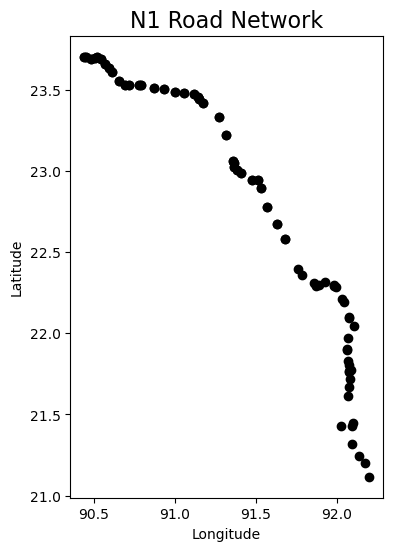

In [7]:
# Plotting function to visualize the road network
def plot_N1(gdf):
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf['start_geometry'].plot(ax=ax, color='black', linewidth=1)

    # Title, labels and grid
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('N1 Road Network', fontsize=16)
    ax.set_aspect('equal')
    plt.show()

plot_N1(gdf)

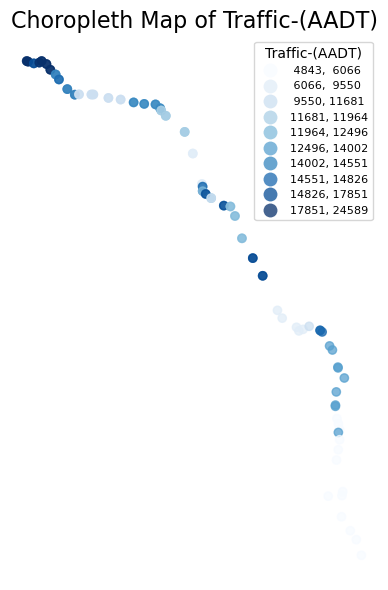

In [8]:
# Create a choropleth map of the road network

def choropleth_map(gdf, column):
    fig, ax = plt.subplots(figsize=(6, 6))

    gdf = gdf.dropna(subset=[column])
    gdf[column] = pd.to_numeric(gdf[column], errors='coerce')

    gdf.plot(column=column, 
            ax=ax,
            scheme='quantiles',
            k=10,
            cmap='Blues',
            alpha=0.75,
            legend_kwds={"title": f"{column}", 
                    #  "loc":"lower center",
                    #  "bbox_to_anchor": (0.62, 0),
                     "fmt": "{:.0f}",
                     'prop': {"size":8}
                     },
            legend=True
    )
    plt.title(f'Choropleth Map of {column}', fontsize=16)
    plt.axis('off')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

choropleth_map(gdf, 'Traffic-(AADT)')

## For all roads

In [9]:
directory_path = '../Assessment1/testfile/RMMS/RMMS/'

all_data = []

# Step 1: Loop through all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('traffic.htm'):  # Only consider files that end with 'traffic.htm'
        # Construct full file path
        file_path = os.path.join(directory_path, filename)

        # Step 1: Read the HTML table without skipping any rows initially
        tables = pd.read_html(file_path, flavor='lxml')

        # Step 2: Use the correct table index (based on your inspection, it's likely index 0)
        raw_df = tables[2]

        # Step 3: Drop rows that are entirely NaN
        raw_df = raw_df.dropna(how='all')

        # Step 4: Reset index to make processing easier
        raw_df = raw_df.reset_index(drop=True)
        raw_df = raw_df.drop([0, 1, 2])

        # Step 5: Locate the actual column headers (usually at row index 1 or 2)
        # For this file, headers appear to be on row index 1
        row1 = raw_df.iloc[0].astype(str)
        row2 = raw_df.iloc[1].astype(str)
        combined_headers = row1 + "-" + row2
        combined_headers = combined_headers.str.replace('-nan', '')

        # Step 6: Create final DataFrame
        df = raw_df[1:]  # Data starts after header row
        df.columns = combined_headers  # Set 

        # Step 7: Reset index
        df = df.reset_index(drop=True)
        df = df[df['Link no'].notna()]

        df.rename(columns={df.columns[0]: "Link no"}, inplace=True)
        df.set_index('Link no', inplace=True)

        # Step 8: Drop rows that are entirely NaN except the first column
        df = df.dropna(axis=0, how='all')

        all_data.append(df)

# Step 11: Combine all DataFrames in the list into a single large DataFrame
final_df = pd.concat(all_data, axis=0)
final_df = final_df.reset_index()

# Optionally, display the final combined DataFrame
display(final_df)


,Link no,Name,Start location-LRP,Start location-Offset,Start location-Chainage,End location-LRP,End location-Offset,End location-Chainage,Length-(Km),Traffic Data-Heavy Truck,...,Traffic Data-Car,Traffic Data-Auto Rickshaw,Traffic Data-Motor Cycle,Traffic Data-Bi-Cycle,Traffic Data-Cycle Rickshaw,Traffic Data-Cart,Total-Motorized,Total-Non Motorized,Total-Total AADT,Traffic-(AADT)
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0,LRPS,822,0.822,0.822,402.0,...,1851.0,2980.0,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0,LRPS,822,0.822,0.822,660.0,...,2608.0,2508.0,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0
2,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,660.0,...,2608.0,2508.0,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0
3,N1-2R,Int.with Z1101 - Signboard (Left) R111 (Right),LRPS,822,0.822,LRPS,4175,4.175,3.353,402.0,...,1851.0,2980.0,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0
4,N1-3L,Signboard - Shimrail (Left)R110 (Left),LRPS,4175,4.175,LRPS,7181,7.181,3.006,91.0,...,1690.0,2266.0,1087.0,75.0,1198.0,0.0,16288.0,1273.0,17561.0,17561.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,Z8915-3,Int.with Z8916 - Daulatkhan,LRP010,1150,10.47,LRP014,2290,15.66,5.190,0.0,...,25.0,1025.0,872.0,396.0,380.0,0.0,2341.0,776.0,3117.0,3117.0
2062,Z8916-1,Guingerhat (Int.with R890) - Int.with Z8915,LRPS,0,0,LRP004,3626,7.626,7.626,0.0,...,15.0,672.0,640.0,453.0,524.0,0.0,1463.0,977.0,2440.0,2440.0
2063,Z8916-2,Int.with Z8915 - Daulatkhan Bazar,LRP004,3626,7.626,LRP005,6600,11.591,3.965,0.0,...,15.0,672.0,640.0,453.0,524.0,0.0,1463.0,977.0,2440.0,2440.0
2064,Z8943-1,Tazumuddin (Int.with Z8905) - Fakirhat (Int.wi...,LRPS,0,0,LRPS,6446,6.446,6.446,0.0,...,42.0,912.0,679.0,528.0,584.0,0.0,1971.0,1112.0,3083.0,3083.0


# Link this to the geometry datasets

In [10]:
# geometry dataset
file_path = '../Assessment1/testfile/WBSIM_Lab1_2024_Cleaned/WBSIM_Lab1_2024_Cleaned/infrastructure/_roads3.csv'
roads = pd.read_csv(file_path)
roads.head()

# Ensure chainage columns are numeric for reliable matching
final_df['Start location-Chainage'] = pd.to_numeric(final_df['Start location-Chainage'], errors='coerce')
final_df['End location-Chainage'] = pd.to_numeric(final_df['End location-Chainage'], errors='coerce')
roads['chainage'] = pd.to_numeric(roads['chainage'], errors='coerce')

# Extract the road name from 'Link no' (everything before the first '-')
final_df['road'] = final_df['Link no'].str.split('-').str[0]

# Merge to find start geometry
start_merge = pd.merge(
    final_df[['road', 'Start location-Chainage']],
    roads[['road', 'chainage', 'lat', 'lon']],
    left_on=['road', 'Start location-Chainage'],
    right_on=['road', 'chainage'],
    how='left'
).rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})

# Merge to find end geometry
end_merge = pd.merge(
    final_df[['road', 'End location-Chainage']],
    roads[['road', 'chainage', 'lat', 'lon']],
    left_on=['road', 'End location-Chainage'],
    right_on=['road', 'chainage'],
    how='left'
).rename(columns={'lat': 'end_lat', 'lon': 'end_lon'})

# Create geometry columns using shapely Point or simple tuples
final_df['start_geometry'] = [Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None 
                        for xy in zip(start_merge['start_lon'], start_merge['start_lat'])]

final_df['end_geometry'] = [Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None 
                      for xy in zip(end_merge['end_lon'], end_merge['end_lat'])]

# Drop temporary 'road' column if not needed
final_df = final_df.drop(columns=['road'])
final_gdf = gpd.GeoDataFrame(final_df, geometry='start_geometry') # Keep only the start geometry for now
final_gdf

,Link no,Name,Start location-LRP,Start location-Offset,Start location-Chainage,End location-LRP,End location-Offset,End location-Chainage,Length-(Km),Traffic Data-Heavy Truck,...,Traffic Data-Motor Cycle,Traffic Data-Bi-Cycle,Traffic Data-Cycle Rickshaw,Traffic Data-Cart,Total-Motorized,Total-Non Motorized,Total-Total AADT,Traffic-(AADT),start_geometry,end_geometry
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0.000,LRPS,822,0.822,0.822,402.0,...,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0,POINT (90.44333 23.70603),POINT (90.4504722 23.7027778)
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0.000,LRPS,822,0.822,0.822,660.0,...,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0,POINT (90.44333 23.70603),POINT (90.4504722 23.7027778)
2,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,660.0,...,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0,POINT (90.45047 23.70278),POINT (90.4805271 23.6938052)
3,N1-2R,Int.with Z1101 - Signboard (Left) R111 (Right),LRPS,822,0.822,LRPS,4175,4.175,3.353,402.0,...,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0,POINT (90.45047 23.70278),POINT (90.4805271 23.6938052)
4,N1-3L,Signboard - Shimrail (Left)R110 (Left),LRPS,4175,4.175,LRPS,7181,7.181,3.006,91.0,...,1087.0,75.0,1198.0,0.0,16288.0,1273.0,17561.0,17561.0,POINT (90.48053 23.69381),POINT (90.5092778 23.6979163)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,Z8915-3,Int.with Z8916 - Daulatkhan,LRP010,1150,10.470,LRP014,2290,15.660,5.190,0.0,...,872.0,396.0,380.0,0.0,2341.0,776.0,3117.0,3117.0,None,POINT (90.7531667 22.5996941)
2062,Z8916-1,Guingerhat (Int.with R890) - Int.with Z8915,LRPS,0,0.000,LRP004,3626,7.626,7.626,0.0,...,640.0,453.0,524.0,0.0,1463.0,977.0,2440.0,2440.0,POINT (90.66172 22.6255),None
2063,Z8916-2,Int.with Z8915 - Daulatkhan Bazar,LRP004,3626,7.626,LRP005,6600,11.591,3.965,0.0,...,640.0,453.0,524.0,0.0,1463.0,977.0,2440.0,2440.0,None,POINT (90.7466663 22.5978886)
2064,Z8943-1,Tazumuddin (Int.with Z8905) - Fakirhat (Int.wi...,LRPS,0,0.000,LRPS,6446,6.446,6.446,0.0,...,679.0,528.0,584.0,0.0,1971.0,1112.0,3083.0,3083.0,POINT (90.84947 22.42644),None


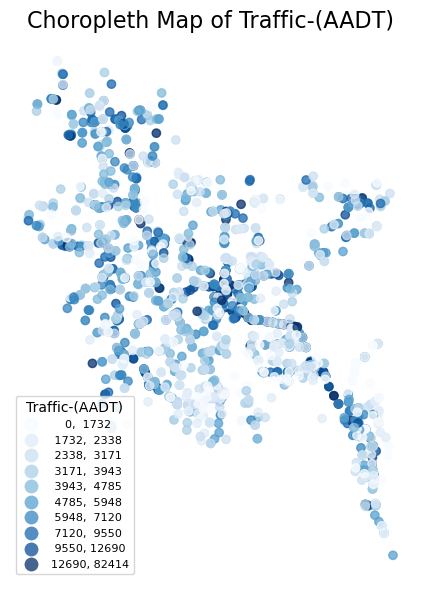

In [11]:
choropleth_map(final_gdf, 'Traffic-(AADT)')

In [12]:
# Export gdf to csv
final_gdf.to_csv('gdf_roads.csv', index=False)